# Kickstarter Success Prediction

This notebook builds a machine learning pipeline to predict whether a Kickstarter campaign will succeed or fail.

## 🎯 Objective:
Classify Kickstarter projects as **successful** or **failed** based on historical features.

## 📊 Dataset:
**Source**: [Kickstarter Projects on Kaggle](https://www.kaggle.com/datasets/kemical/kickstarter-projects)

The dataset contains 300,000+ records of past campaigns, including:
- Launch/deadline dates
- Goal amounts
- Country, currency, and category
- Final state (`successful`, `failed`, etc.)

We use only the `successful` and `failed` rows for binary classification.

### 🧠 Kickstarter Success Prediction with ANN

This notebook builds an artificial neural network pipeline to predict whether a Kickstarter campaign will succeed or fail.

## 🎯 Objective
Classify Kickstarter projects as **successful** or **failed** using ANN after preprocessing, feature engineering, and SMOTE.

---

### 📦 1. Imports

In [508]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

---
### 📂 2. Load & Inspect Dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB
None


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


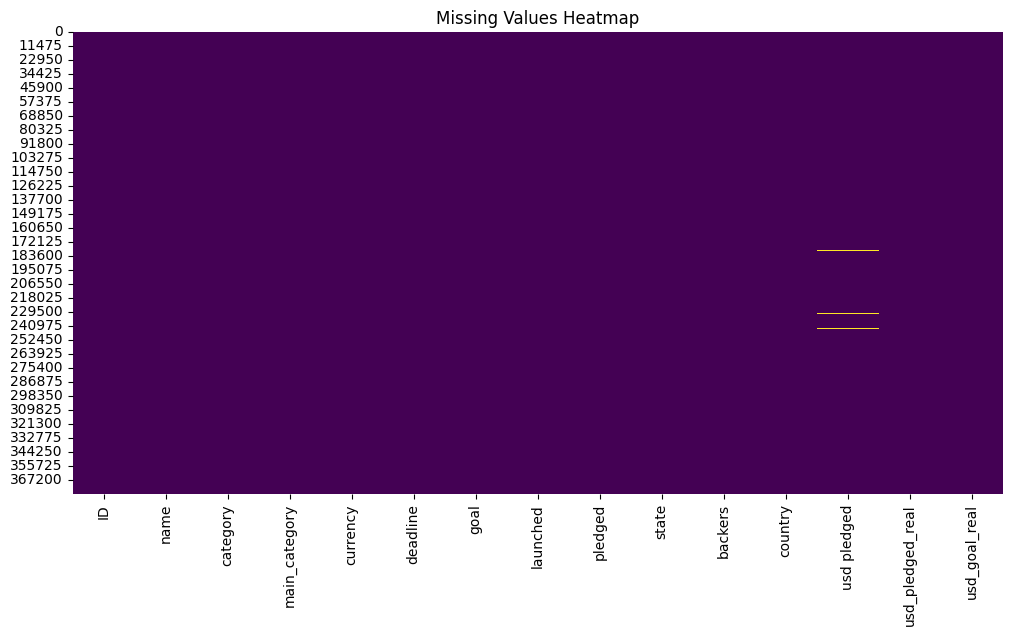

In [509]:
data = pd.read_csv(r'E:\ML_Project\kickstarter-success-prediction\data\ks-projects-201801.csv')
print(data.info())
display(data.head())
plt.figure(figsize=(12, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

---
### 📉 3. Target Distribution

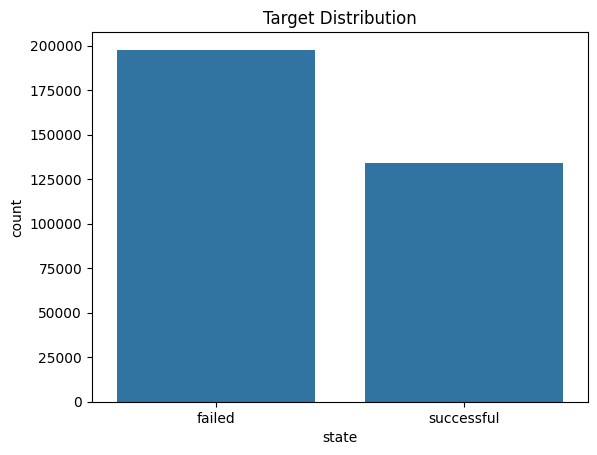

In [510]:
sns.countplot(data=data[data['state'].isin(['failed', 'successful'])], x='state')
plt.title('Target Distribution')
plt.show()

---
### 🧹 4. Data Cleaning

In [511]:
# Drop unneeded columns and filter target
data = data.drop(['ID', 'name'], axis=1)
data = data[data['state'].isin(['failed', 'successful'])].reset_index(drop=True)

# Fill missing values
data['usd pledged'] = data['usd pledged'].fillna(data['usd pledged'].mean())

# Remove leaky columns
leakage_cols = ['pledged', 'usd pledged', 'usd_pledged_real', 'backers']
data.drop(columns=[col for col in leakage_cols if col in data.columns], inplace=True)

# Encode target
data['state'] = data['state'].map({'failed': 0, 'successful': 1})

---
### 🛠️ 5. Feature Engineering

In [512]:
# Dates to datetime
data['deadline'] = pd.to_datetime(data['deadline'], errors='coerce')
data['launched'] = pd.to_datetime(data['launched'], errors='coerce')
data.dropna(subset=['deadline', 'launched'], inplace=True)

# Temporal features
data['duration_days'] = (data['deadline'] - data['launched']).dt.days
data['launch_month'] = data['launched'].dt.month
data['launch_dow'] = data['launched'].dt.dayofweek
data['launch_weekend'] = data['launch_dow'].isin([5, 6]).astype(int)
data['launch_holiday'] = data['launch_month'].isin([11, 12]).astype(int)

# Log transformation and ratios
data['log_goal'] = np.log1p(data['goal'])
data['goal_per_day'] = data['log_goal'] / data['duration_days'].replace(0, 1)

# Drop old date columns
data.drop(columns=['goal', 'deadline', 'launched'], inplace=True)

# Binning & interaction
data['duration_bins'] = pd.cut(data['duration_days'], bins=[0, 15, 30, 60, 1000], labels=False)
data['goal_bins'] = pd.qcut(data['log_goal'], q=4, labels=False)
data['goal_weekend_interaction'] = data['goal_per_day'] * data['launch_weekend']

# Polynomial features
data['duration_squared'] = data['duration_days'] ** 2
data['goal_log_squared'] = data['log_goal'] ** 2

---
### 🔢 6. Feature Encoding & Preprocessing Setup

In [513]:
# Reduce category noise
top_categories = data['category'].value_counts().nlargest(20).index
data['category'] = data['category'].apply(lambda x: x if x in top_categories else 'Other')

cat_cols = ['category', 'main_category', 'currency', 'country']
num_cols = [col for col in data.columns if col not in cat_cols + ['state']]

# Optionally drop near-zero variance features
if (data['goal_weekend_interaction'].value_counts(normalize=True).get(0, 0) > 0.95):
    data.drop(columns=['goal_weekend_interaction'], inplace=True)

---
### ⚙️ 7. Preprocessing Pipelines and XGBoost Setup

In [514]:
# Numeric and categorical transformers
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_cols),
    ('cat', categorical_pipeline, cat_cols)
])

# XGBoost pipeline with SMOTE
xgb_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])

---
### 🔀 8. Train/Test Split and Fit XGBoost

In [515]:
# Prepare input and output
X = data.drop('state', axis=1)
y = data['state']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Fit model
xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['usd_goal_real',
                                                   'duration_days',
                                                   'launch_month', 'launch_dow',
                                                   'launch_weekend',
                                                   'launch_holiday', 'log_goal',
                                                   'goal_per_day',
                                                   'duration_bins', 'goal_bins',
                                                   'goal_weekend_interaction',
                                                   'duration_squared',
                                                   'goal_log_...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

---
### 📊 9. Evaluate XGBoost

In [516]:
# Predict
y_pred = xgb_pipeline.predict(X_test)
y_proba = xgb_pipeline.predict_proba(X_test)[:, 1]

# Metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.70      0.71     59316
           1       0.58      0.62      0.60     40187

    accuracy                           0.67     99503
   macro avg       0.65      0.66      0.66     99503
weighted avg       0.67      0.67      0.67     99503

Accuracy: 0.6652060741887179
F1 Score: 0.5976739411359766
ROC AUC: 0.7229702909080102


---
### 📈 10. Confusion Matrix & ROC Curve

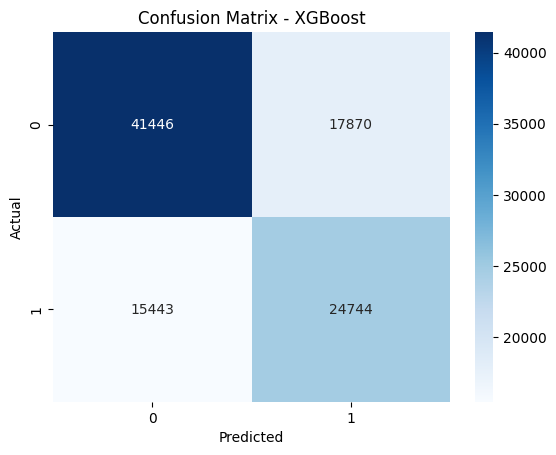

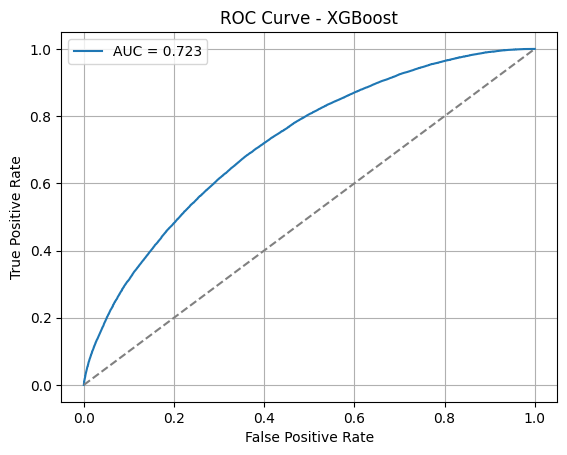

In [517]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], '--', color='gray')
plt.title('ROC Curve - XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()